# Comparison to Kruk (2018)

In [1]:
import os
import re
from tqdm import tqdm
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from astropy.coordinates import SkyCoord
import astropy.units as u

In [2]:
gal_angle_df = pd.read_csv('lib/gal-metadata.csv', index_col=0)
sd = pd.read_csv('../source_files/Kruk2018_Table2_Table3.csv')
sd_coords = SkyCoord(ra=sd['ra']*u.degree, dec=sd['dec']*u.degree)

In [3]:
agg_res_path = 'output_files/aggregation_results'
agg_results = pd.Series([])
with tqdm(os.listdir(agg_res_path)) as bar:
    for f in bar:
         if re.match(r'[0-9]+\.pkl.gz', f):
                agg_results[int(f.split('.')[0])] = pd.read_pickle(join(agg_res_path, f))

100%|██████████| 296/296 [00:04<00:00, 59.93it/s] 


In [4]:
matches = pd.DataFrame([], columns=sd.columns)
with tqdm(agg_results.index) as bar:
    for subject_id in bar:
        gal = gal_angle_df.loc[subject_id]
        sep = sd_coords.separation(
            SkyCoord(ra=gal['RA']*u.degree, dec=gal['DEC']*u.degree)
        )
        idxmin_sep = np.argmin(sep)
        if sep[idxmin_sep] < 1 * u.arcsec:
            matches.loc[subject_id] = sd.iloc[idxmin_sep]

100%|██████████| 296/296 [00:01<00:00, 152.62it/s]


In [5]:
disks = agg_results.apply(lambda res: res.params.get('disk', default=pd.Series([])))
bulges = agg_results.apply(lambda res: res.params.get('bulge', default=pd.Series([])))
bars = agg_results.apply(lambda res: res.params.get('bar', default=pd.Series([])))

disks_e = agg_results.apply(lambda res: res.errors.get('disk', default=pd.Series([])))
bulges_e = agg_results.apply(lambda res: res.errors.get('bulge', default=pd.Series([])))
bars_e = agg_results.apply(lambda res: res.errors.get('bar', default=pd.Series([])))

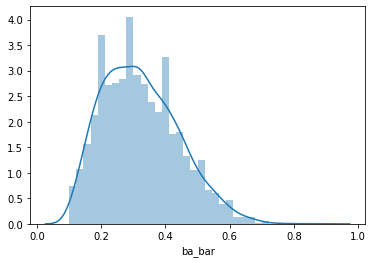

In [6]:
sns.distplot(sd['ba_bar'].replace(0, np.nan).dropna())

In [7]:
scales = 1 / disks.q

Text(0, 0.5, 'Galaxy Builder Aggregate')

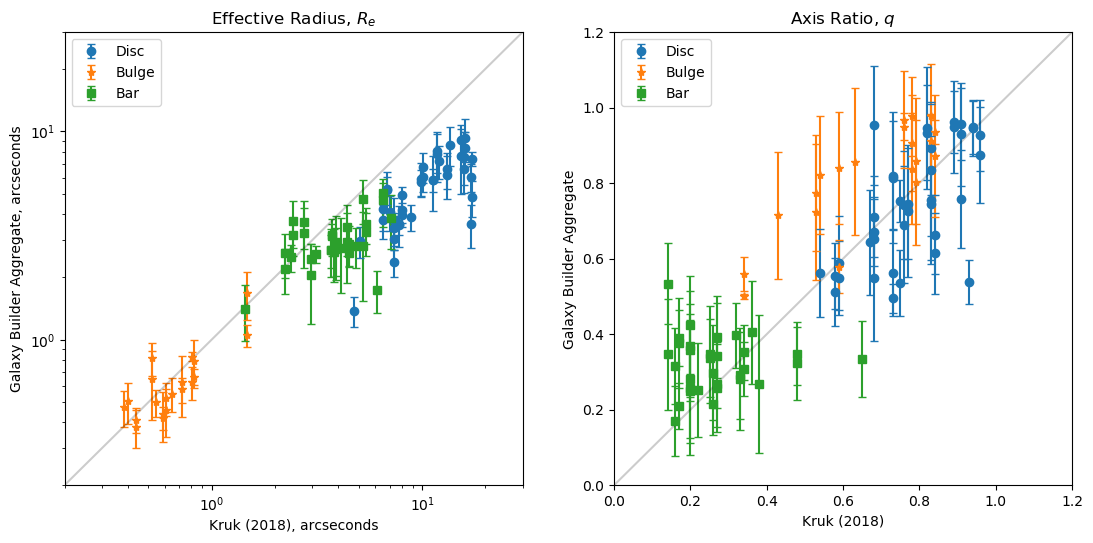

In [59]:
labels = ('Disc', 'Bulge', 'Bar')
fmts = ['o', '*', 's']
f, ax = plt.subplots(ncols=2, figsize=(13, 6), dpi=100)
plt.sca(ax[0])
for i, re_df in enumerate((
    pd.concat((
        disks.Re,
        matches['re_disc'].rename('sk'),
        disks_e.Re.rename('err')
    ), axis=1) * 0.396,
    pd.concat((
        bulges.Re,
        matches['re_bulge'].rename('sk'),
        bulges_e.Re.rename('err')
    ), axis=1) * 0.396,
    pd.concat((
        bars.Re,
        matches['re_bar'].rename('sk'),
        bars_e.Re.rename('err')
    ), axis=1) * 0.396,
)):
    re_df = re_df.dropna()
    plt.errorbar(
        re_df['sk'], re_df['Re'], yerr=re_df['err'],
        fmt=fmts[i], capsize=3, label=labels[i]
    )
plt.legend()
plt.gca().add_line(plt.Line2D((0, 50), (0, 50), c='k', alpha=0.2))
plt.xscale('log')
plt.yscale('log')
plt.xlim(0.2, 30) 
plt.ylim(0.2, 30)
plt.title(r'Effective Radius, $R_e$')
plt.xlabel('Kruk (2018), arcseconds')
plt.ylabel('Galaxy Builder Aggregate, arcseconds')
plt.sca(ax[1])
for i, re_df in enumerate((
    pd.concat((disks.q, matches['ba_disc'].rename('sk'), disks_e.q.rename('err')), axis=1),
    pd.concat((bulges.q, matches['ba_bulge'].rename('sk'), bulges_e.q.rename('err')), axis=1),
    pd.concat((bars.q, matches['ba_bar'].rename('sk'), bars_e.q.rename('err')), axis=1),
)):
    re_df = re_df.replace(0, np.nan).dropna()
#     sns.regplot('sk', 'Re', re_df, ax=plt.gca())
    plt.errorbar(
        re_df['sk'], re_df['q'], yerr=re_df['err'],
        fmt=fmts[i], capsize=3, label=labels[i]
    )
plt.legend()
plt.gca().add_line(plt.Line2D((0, 100), (0, 100), c='k', alpha=0.2))
plt.xlim(0, 1.2) 
plt.ylim(0, 1.2)
plt.title(r'Axis Ratio, $q$')
plt.xlabel('Kruk (2018)')
plt.ylabel('Galaxy Builder Aggregate')

In [40]:
np.logspace(0, 1)

array([ 1.        ,  1.04811313,  1.09854114,  1.1513954 ,  1.20679264,
        1.26485522,  1.32571137,  1.38949549,  1.45634848,  1.52641797,
        1.59985872,  1.67683294,  1.75751062,  1.84206997,  1.93069773,
        2.02358965,  2.12095089,  2.22299648,  2.32995181,  2.44205309,
        2.55954792,  2.6826958 ,  2.8117687 ,  2.9470517 ,  3.0888436 ,
        3.23745754,  3.39322177,  3.55648031,  3.72759372,  3.90693994,
        4.09491506,  4.29193426,  4.49843267,  4.71486636,  4.94171336,
        5.17947468,  5.42867544,  5.68986603,  5.96362332,  6.25055193,
        6.55128557,  6.86648845,  7.19685673,  7.54312006,  7.90604321,
        8.28642773,  8.68511374,  9.10298178,  9.54095476, 10.        ])

(1, 10)

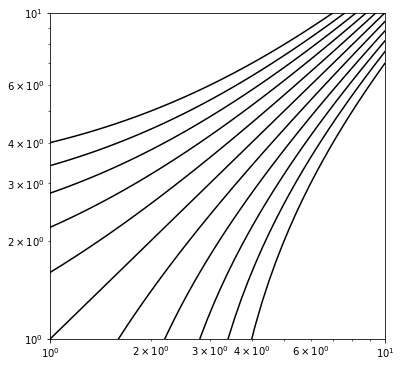

In [53]:
plt.figure(figsize=(6, 6))
x = np.logspace(0, 1)
for i in np.linspace(-3, 3, 11):
    plt.plot(x, x+i, 'k')
plt.xscale('log')
plt.yscale('log')
plt.xlim(1, 10) 
plt.ylim(1, 10)